In [1]:
%load_ext autoreload
%autoreload 2

import os, torch, click, numpy as np
import datetime

import swyft
from utils import *
from plot import *

from tqdm import tqdm
from data_mgmt import get_paths, get_ids
import pickle




DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

import matplotlib.colors
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 15})



In [2]:
def restrictions(file, start, end):
    return (file.endswith(end) and file.startswith(start))

path = '../data/pred/'
files = os.listdir(path)
for file in files:
    if restrictions(file, 'pred_real', 'pickle'):
        full_path = os.path.join(path, file)
        print(full_path)

../data/pred/pred_real_m_1_nsub_1_nsim_50000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_1_nsim_50000_sigma_0.1_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_1_nsim_10000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_3_nsim_50000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_1_nsim_50000_sigma_0.5_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_1_nsim_5000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_1_nsim_100000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_5_nsim_50000_sigma_0.0_nmc_1_npred_0.pickle


In [3]:
m = 1
nsub = 1
# nsubs = [1, 3]
nsim = 50000
nsims = [5000, 10000, 50000, 100000]
nmc = 1
npred = 0 #nsim
sigma = 0.0
# sigmas = [0.0, 0.1, 0.5, 1.0, 2.0, 100.0] 
# sigmas = [0.0, 0.1, 0.5]
sigmas = [0.0]
zero = 'real'

entries = []
# for sigma in sigmas:
for nsim in nsims:
    entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero=zero)
    entries.append(entry)
    
    print(entry)
n_entries = len(entries)

{'m': 1, 'nsub': 1, 'nsim': 5000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'real'}
{'m': 1, 'nsub': 1, 'nsim': 10000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'real'}
{'m': 1, 'nsub': 1, 'nsim': 50000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'real'}
{'m': 1, 'nsub': 1, 'nsim': 100000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'real'}


In [4]:
def get_pred(entry):
    _, _, _, pred_path = get_paths(entry)
    
    with open(pred_path, 'rb') as f:
        pred = pickle.load(f)
        
    posts, targets, obs0s, v0s, obs0_is = list(pred.values())
    return posts, targets, obs0s, v0s, obs0_is

posts_all = []
targets_all = []
obs0s_all = []
v0s_all = []
obs0_is_all = []

for entry in entries:
    posts, targets, obs0s, v0s, obs0_is = get_pred(entry)
    
    posts_all.append(posts)
    targets_all.append(targets)
    obs0s_all.append(obs0s)
    v0s_all.append(v0s)
    obs0_is_all.append(obs0_is)
    

In [5]:
def get_f(posts, targets, x):
    
    x1, x2 = x[:-1], x[1:]
    
    def f1(xi):
        y = targets[posts > xi]
        return y.sum() / len(y) if y.sum() != 0 else 0
        
    def f2(xi, xj):
        y = targets[(posts > xi) & (posts < xj)]
        return y.sum() / len(y) if y.sum() != 0 else 0
    
    def f3(xj):
        y = targets[posts < xj]
        return y.sum() / len(y) if y.sum() != 0 else 0
    
    ret1 = np.array([f1(xi) for xi in zip(x1)])
    ret2 = np.array([f2(xi, xj) for xi, xj in zip(x1, x2)])
    ret3 = np.array([f3(xj) for xj in zip(x2)])

    return ret1, ret2, ret3

def get_f(posts, targets, x):
    
    x1, x2 = x[:-1], x[1:]
    
    
    def f3(xi, xj):
        y = targets[(posts > xi) & (posts <= xj)]
        return y.sum() / len(y) if y.sum() != 0 else 0

    return np.array([f3(xi, xj) for xi, xj in zip(x1, x2)])

In [6]:
def get_tc(i, v0, target):
    y, x, m = v0.reshape(-1, 3).T
#     m_i = np.where(target == 1)[0]
#     target_coords = np.array((m_i, x, y)).T
    
    m_i = np.full(len(x), i)
    target_coords = np.array((m_i, x, y)).T

    return target_coords

def get_target_coords(i, v0s):
    return np.concatenate([get_tc(j, v0s[j], targets[j]) for j in range(i)])

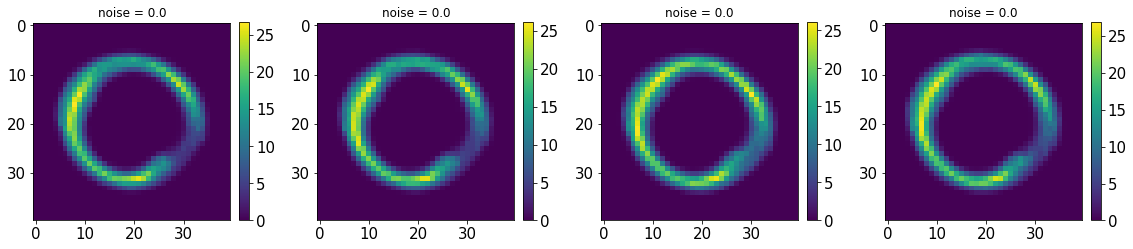

In [7]:
plt_imshow( np.array([obs0s[0] for obs0s in obs0s_all]),
#            nrows = 2,
           titles = [f"noise = {entry['sigma']}" for entry in entries], 
           cbar = True, tl = True, y = 4 )

In [8]:

for entry in entries:
    posts, targets, obs0s, v0s, obs0_is = get_pred(entry)
    
    l = 3
    
#     plt_imshow( obs0s[:l], target_coords = get_target_coords(l, v0s), **imkwargs, cbar = True)
#     plt_imshow( posts.squeeze()[:l], target_coords = get_target_coords(l, v0s), **imkwargs, cbar = True)


In [9]:
def temp_prior(entries):
    L = 40
    priors =  [entry['nsub'] / (L*L) / entry['nmc']  for entry in entries]
    assert all([prior == priors[0] for prior in priors])
    return priors[0]
        
prior_freq = temp_prior(entries)

In [10]:
n_alpha = 50
alpha_edges = np.linspace(0, 1, n_alpha)
alpha_centers = (alpha_edges[:-1] + alpha_edges[1:])/2

In [12]:
alpha_edges_log = np.logspace(-9, 0, n_alpha)

In [13]:
alpha_edges_log

array([1.00000000e-09, 1.52641797e-09, 2.32995181e-09, 3.55648031e-09,
       5.42867544e-09, 8.28642773e-09, 1.26485522e-08, 1.93069773e-08,
       2.94705170e-08, 4.49843267e-08, 6.86648845e-08, 1.04811313e-07,
       1.59985872e-07, 2.44205309e-07, 3.72759372e-07, 5.68986603e-07,
       8.68511374e-07, 1.32571137e-06, 2.02358965e-06, 3.08884360e-06,
       4.71486636e-06, 7.19685673e-06, 1.09854114e-05, 1.67683294e-05,
       2.55954792e-05, 3.90693994e-05, 5.96362332e-05, 9.10298178e-05,
       1.38949549e-04, 2.12095089e-04, 3.23745754e-04, 4.94171336e-04,
       7.54312006e-04, 1.15139540e-03, 1.75751062e-03, 2.68269580e-03,
       4.09491506e-03, 6.25055193e-03, 9.54095476e-03, 1.45634848e-02,
       2.22299648e-02, 3.39322177e-02, 5.17947468e-02, 7.90604321e-02,
       1.20679264e-01, 1.84206997e-01, 2.81176870e-01, 4.29193426e-01,
       6.55128557e-01, 1.00000000e+00])

In [ ]:
np.concatenate(np.array([]))

In [14]:
fs_raw = np.array([get_f(posts, targets, alpha_edges) for posts, targets in zip(posts_all, targets_all)])

In [61]:
fs_raw_log = np.array([get_f(posts, targets, alpha_edges_log) for posts, targets in zip(posts_all, targets_all)])

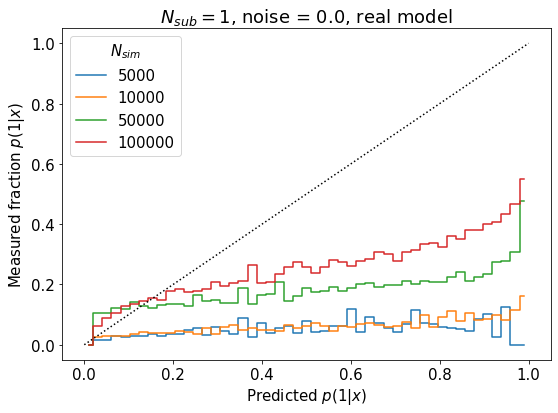

In [14]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6), tight_layout = True)

ax = axs

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for f, entry, color in zip(fs_raw, entries, colors):
    ax.step(alpha_centers, f, label = f"{entry['nsim']}", where='mid', color = color)
ax.plot([0, 1], [0, 1], "k:")
# ax.plot([0, 1], [prior_freq, prior_freq], "k--")
ax.set_xlabel(r'Predicted $p(1|x)$')
ax.set_ylabel(r'Measured fraction $p(1|x)$')
ax.set_title(rf'$N_{{sub}} = {nsub}$, noise = {sigma}, {zero} model')
ax.legend(title = r'$N_{sim}$')

plt.show()

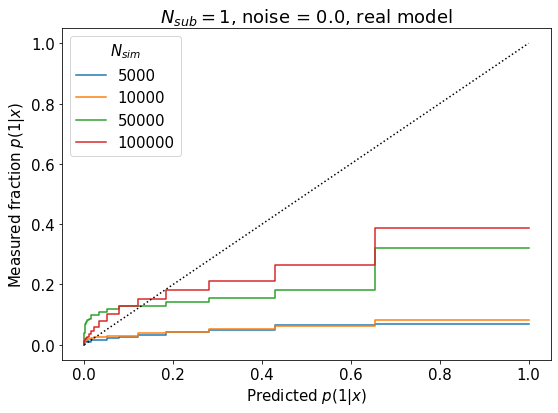

In [66]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6), tight_layout = True)

ax = axs

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for f, entry, color in zip(fs_raw_log, entries, colors):
    ax.step(alpha_edges_log[1:], f, label = f"{entry['nsim']}", where='pre', color = color)
ax.plot([0, 1], [0, 1], "k:")
# ax.plot([0, 1], [prior_freq, prior_freq], "k--")
ax.set_xlabel(r'Predicted $p(1|x)$')
ax.set_ylabel(r'Measured fraction $p(1|x)$')
ax.set_title(rf'$N_{{sub}} = {nsub}$, noise = {sigma}, {zero} model')
ax.legend(title = r'$N_{sim}$')

plt.show()

In [15]:
parms_log = np.polyfit(alpha_edges_log[1:], fs_raw_log.T, 3).T

posts_calib_all_fit_log = []

for posts, parm_log in zip(posts_all, parms_log):
    posts_calib_fit_log = np.poly1d(parm_log)(posts) 
    posts_calib_all_fit_log.append(posts_calib_fit_log)
    
fs_calib_fit_log = np.array([get_f(posts_calib_fit_log, targets, alpha_edges_log) for posts_calib_fit_log, targets in zip(posts_calib_all_fit_log, targets_all)])

NameError: name 'fs_raw_log' is not defined

In [16]:
parms = np.polyfit(alpha_centers, fs_raw.T, 5).T

posts_calib_all_fit = []

for posts, parm in zip(posts_all, parms):
    posts_calib_fit = np.poly1d(parm)(posts) 
    posts_calib_all_fit.append(posts_calib_fit)
    
fs_calib_fit = np.array([get_f(posts_calib_fit, targets, alpha_edges) for posts_calib_fit, targets in zip(posts_calib_all_fit, targets_all)])

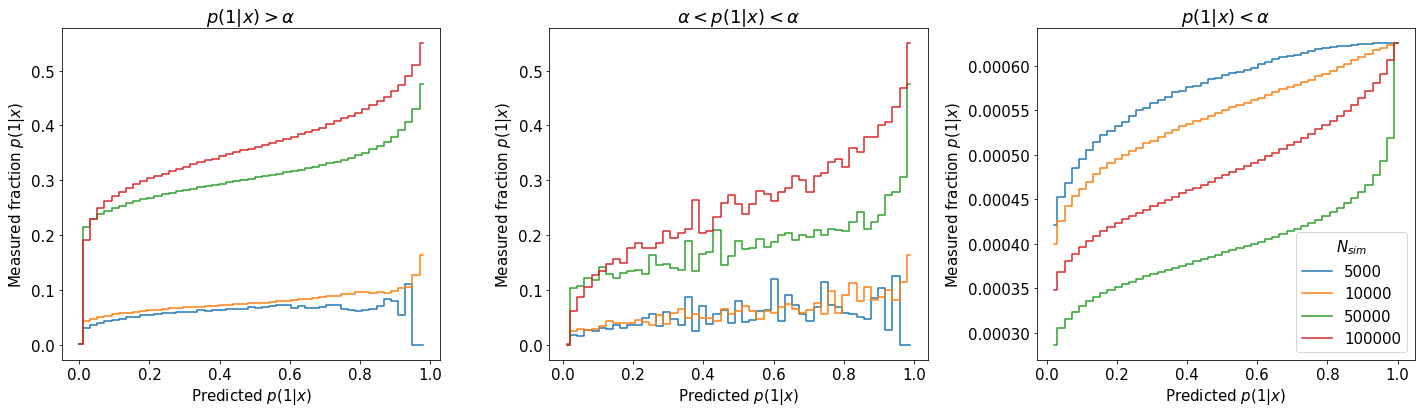

In [38]:
fig, axs = plt.subplots(1, 3, figsize = (20, 6), tight_layout = True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
titles = [r'$p(1|x)>\alpha$', r'$\alpha<p(1|x)<\alpha$', r'$p(1|x)<\alpha$']


for ax, fs, alpha, title in zip(axs, ff, [alpha_edges[:-1], alpha_centers, alpha_edges[1:]], titles):
    for f, entry, color in zip(fs, entries, colors):
        ax.step(alpha, f, label = f"{entry['nsim']}", where='mid', color = color)
#     ax.plot([0, 1], [0, 1], "k:")
    # ax.plot([0, 1], [prior_freq, prior_freq], "k--")
    ax.set_xlabel(r'Predicted $p(1|x)$')
    ax.set_ylabel(r'Measured fraction $p(1|x)$')
    ax.set_title(title)
#     ax.set_title(rf'$N_{{sub}} = {nsub}$, noise = {sigma}, {zero} model')
ax.legend(title = r'$N_{sim}$')

plt.show()

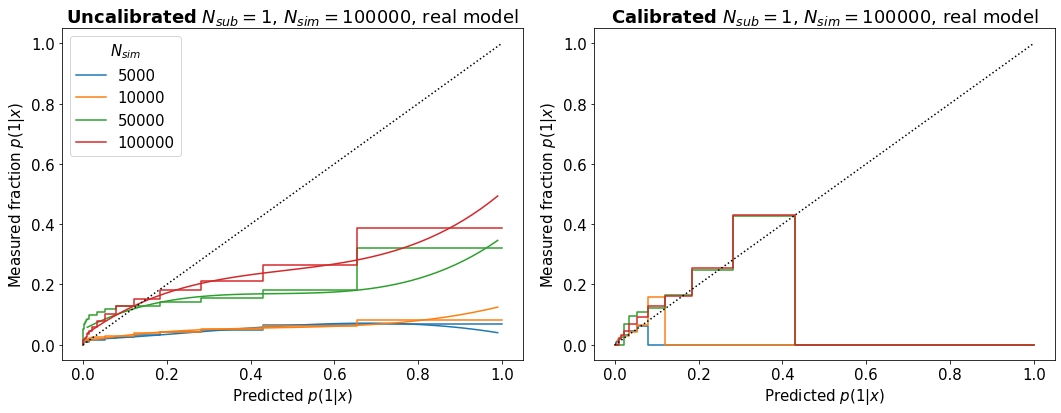

In [70]:
fig, axs = plt.subplots(1, 2, figsize = (15, 6), tight_layout = True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
titles = ['Uncalibrated', 'Calibrated']

for ax, fs, title in zip(axs, [fs_raw_log, fs_calib_fit_log], titles):
    
    for f, entry, color, parm in zip(fs, entries, colors, parms):
        ax.step(alpha_edges_log[1:], f, label = f"{entry['nsim']}", where='pre', color = color)
        if ax == axs[0]:
            ax.plot(alpha_centers, np.poly1d(parm)(alpha_centers), color = color)
    ax.plot([0, 1], [0, 1], "k:")
    ax.set_xlabel(r'Predicted $p(1|x)$')
    ax.set_ylabel(r'Measured fraction $p(1|x)$')
    ax.set_title(rf'$\bf{title}$ $N_{{sub}} = {nsub}$, $N_{{sim}} = {nsim}$, {zero} model')
axs[0].legend(title = r'$N_{sim}$')

plt.show()

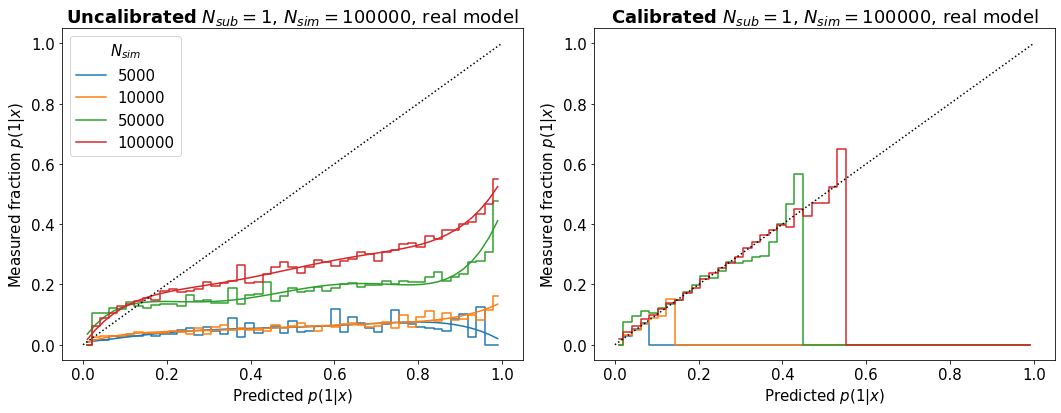

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (15, 6), tight_layout = True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
titles = ['Uncalibrated', 'Calibrated']

for ax, fs, title in zip(axs, [fs_raw, fs_calib_fit], titles):
    
    for f, entry, color, parm in zip(fs, entries, colors, parms):
        ax.step(alpha_centers, f, label = f"{entry['nsim']}", where='mid', color = color)
        if ax == axs[0]:
            ax.plot(alpha_centers, np.poly1d(parm)(alpha_centers), color = color)
    ax.plot([0, 1], [0, 1], "k:")
    ax.set_xlabel(r'Predicted $p(1|x)$')
    ax.set_ylabel(r'Measured fraction $p(1|x)$')
    ax.set_title(rf'$\bf{title}$ $N_{{sub}} = {nsub}$, $N_{{sim}} = {nsim}$, {zero} model')
axs[0].legend(title = r'$N_{sim}$')

plt.show()

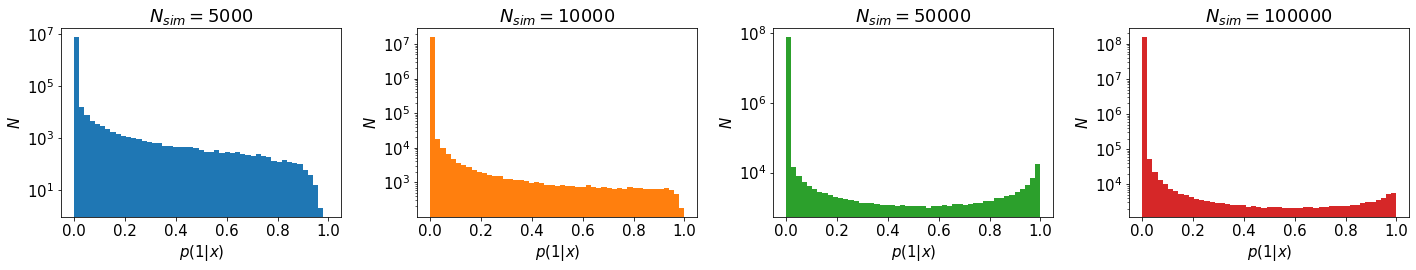

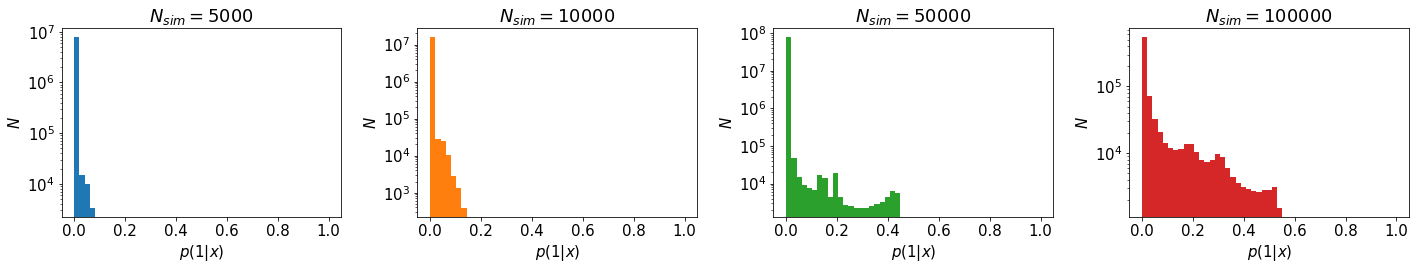

In [89]:
for posts_alls in [posts_all, posts_calib_all_fit]:

    fig, axs = plt.subplots(1, n_entries, figsize = (20, 4), tight_layout = True)

    for ax, posts, entry, color in zip(axs, posts_alls, entries, colors):
        ax.hist(posts.flatten(), bins = alpha_edges, color = color)
        ax.set_yscale('log')
        ax.set_xlabel(r'$p(1|x)$')
        ax.set_ylabel(r'$N$')
        ax.set_title(rf"$N_{{sim}} = {entry['nsim']}$")

    plt.show()

In [51]:
1e0

1.0

In [58]:
np.min(posts_calib_all_fit[-1]), np.min(posts_all[-1])

(0.027308933427438474, 1.5959058454811766e-15)

In [ ]:
assert 1 == 2

In [42]:
posts2 = np.copy(posts)

In [43]:
for xi, xj, xc in zip(alpha_edges[:-1], alpha_edges[1:], alpha_centers):
    posts2 = np.where((posts > xi) & (posts < xj), xc, posts2)

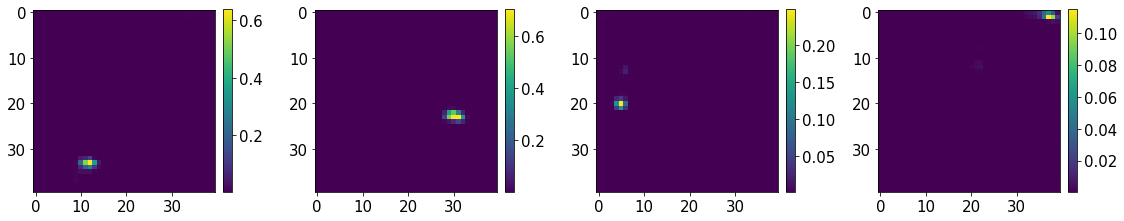

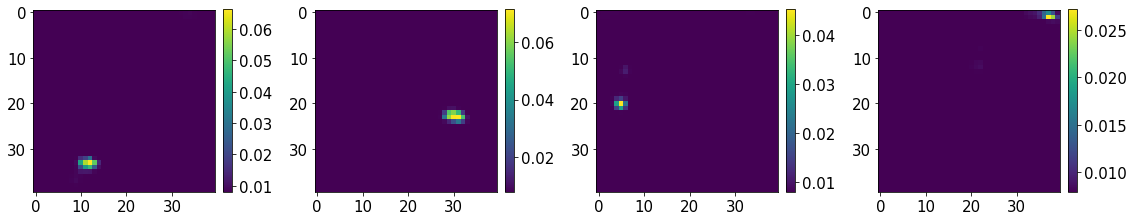

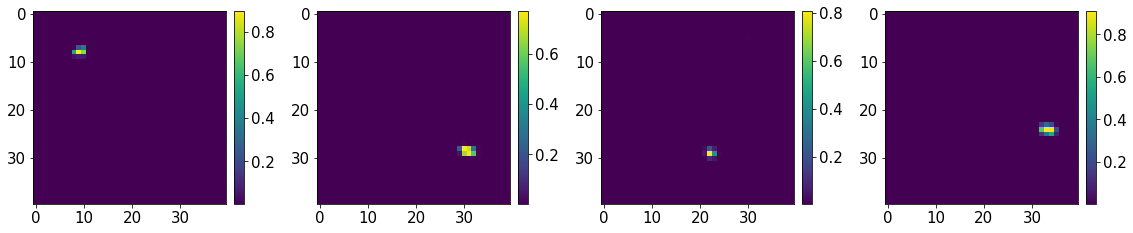

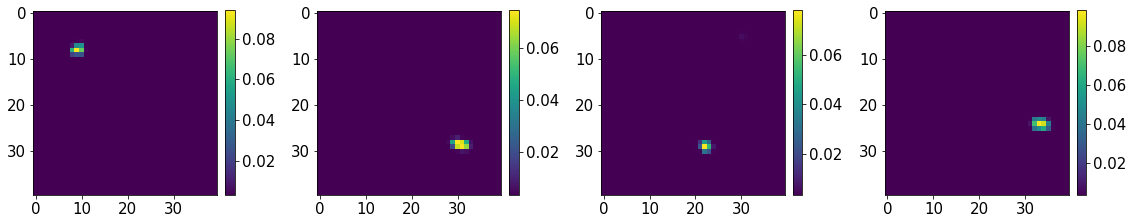

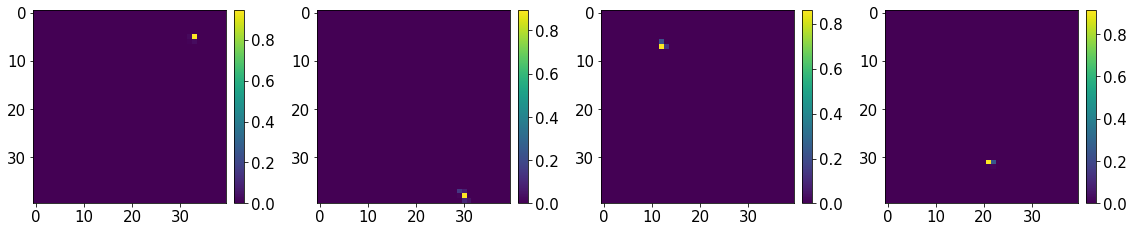

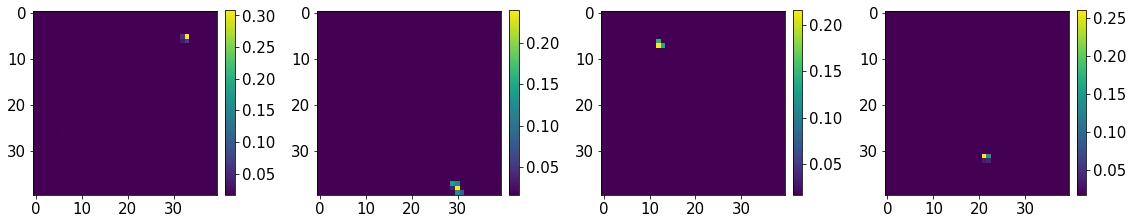

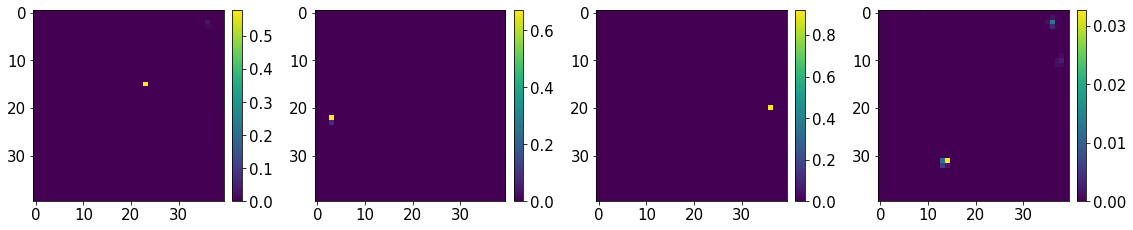

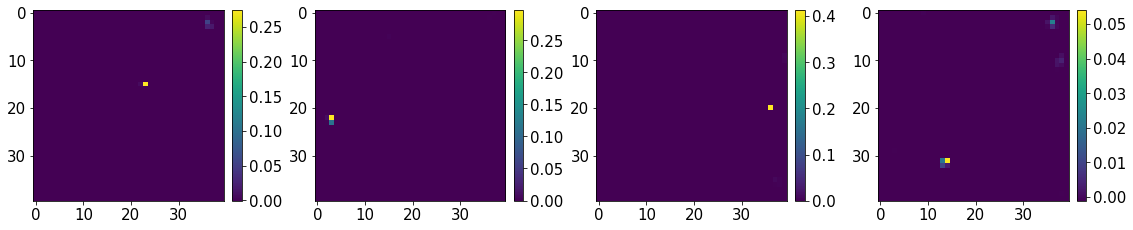

In [18]:
# posts = posts_all[-1]
# posts_calib = posts_calib_all_fit[-1]

for posts, posts_calib_fit in zip(posts_all, posts_calib_all_fit):

    plots = [posts, posts_calib_fit]

    for plot in plots:
#         for zlog in [False, True]:
        plt_imshow( plot[:4].squeeze(), cbar = True, tl = True, zlog = False)
#         plt_imshow( plot[:4].squeeze(), cbar = True, tl = True, zlog = True)
#         plt_imshow( plot[:4].squeeze(), cbar = True, tl = True, zlog = True, zlogmin = 1e-9, zlogmax = 1e0)


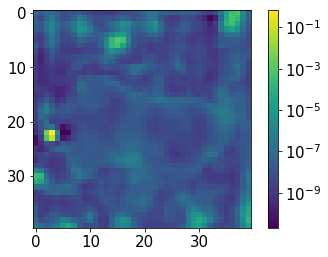

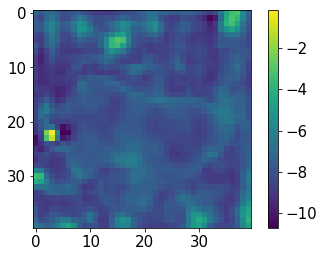

In [41]:
plt.imshow( posts[1].squeeze() , norm = LogNorm())
plt.colorbar()
plt.show()

plt.imshow( np.log10(posts[1].squeeze()))
plt.colorbar()
plt.show()

In [46]:
np.max(posts_calib_fit[1])

0.28591256317467634

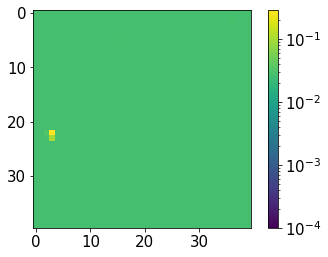

In [49]:
plt.imshow( posts_calib_fit[1].squeeze() , norm = LogNorm(vmin = 0.0001))
plt.colorbar()

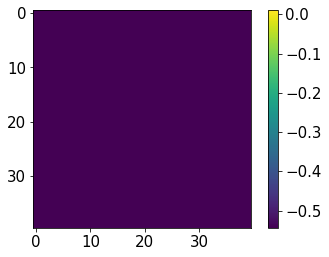

In [42]:
plt.imshow( np.log10(posts_calib_fit[1].squeeze())) 
plt.colorbar()

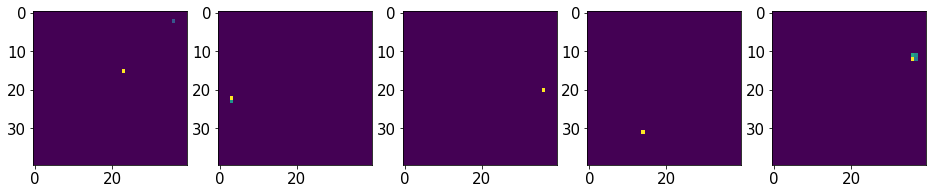

In [49]:
plt_imshow( posts2[:5].squeeze() , zlog = True)

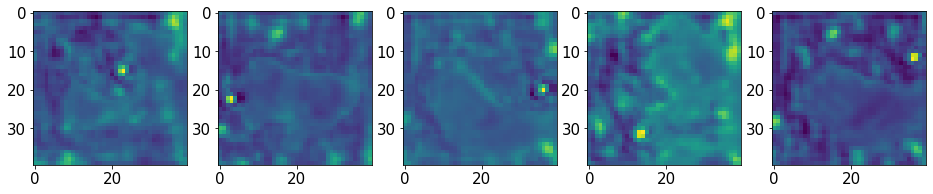

In [48]:
plt_imshow( posts[:5].squeeze() , zlog = True)

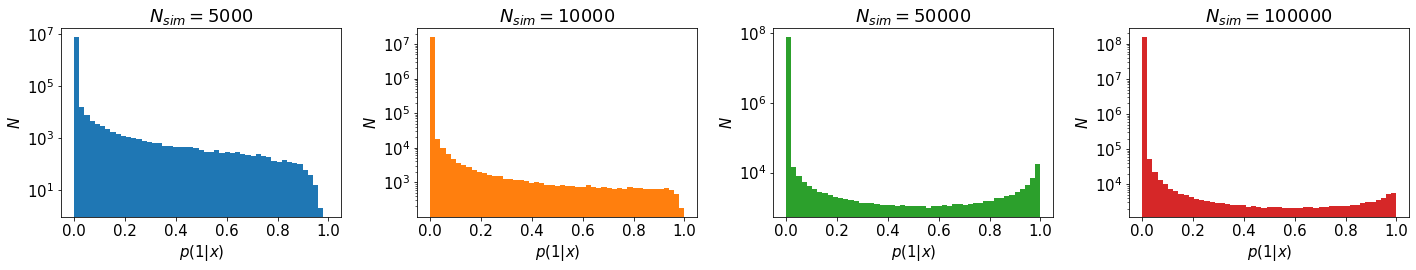

In [13]:
fig, axs = plt.subplots(1, n_entries, figsize = (20, 4), tight_layout = True)

# axs = [axs]
    
for ax, posts, entry, color in zip(axs, posts_all, entries, colors):
    ax.hist(posts.flatten(), bins = alpha_edges, color = color)
    ax.set_yscale('log')
    ax.set_xlabel(r'$p(1|x)$')
    ax.set_ylabel(r'$N$')
    ax.set_title(rf"$N_{{sim}} = {entry['nsim']}$")
    

# for ax, entry, posts, color in zip(axs[-1:], entries[-1:], posts_all[-1:], colors[-1:]):
#     h, _, _  = ax.hist(posts[:10].flatten(), color = color)
#     ax.set_xlabel(r'$p(1|x)$')
#     ax.set_ylabel(r'$N$')
#     ax.set_title(rf"noise = {entry['sigma']}")
#     ax.axvline(x = prior_freq, ymin = 0, ymax = max(h))


plt.show()

# CDF

In [77]:
fs_raw.shape

(4, 49)

In [42]:
fs_cumsum = np.cumsum(fs_raw, axis = 1)
# fs_cumsum /= np.max(fs_cumsum, axis = 1)[:, np.newaxis]

ideal = np.cumsum(alpha_centers)
# ideal /= np.max(ideal)

In [43]:
parms_cumsum = np.polyfit(alpha_centers, fs_cumsum.T, 3).T

posts_calib_cumsum_all_fit = []

for posts, parm in zip(posts_all, parms_cumsum):
    posts_calib_cumsum_fit = np.poly1d(parm)(posts) 
    posts_calib_cumsum_all_fit.append(posts_calib_cumsum_fit)
    
# fs_calib_fit = np.array([get_f(posts_calib_fit, targets, alpha_edges) for posts_calib_fit, targets in zip(posts_calib_all_fit, targets_all)])

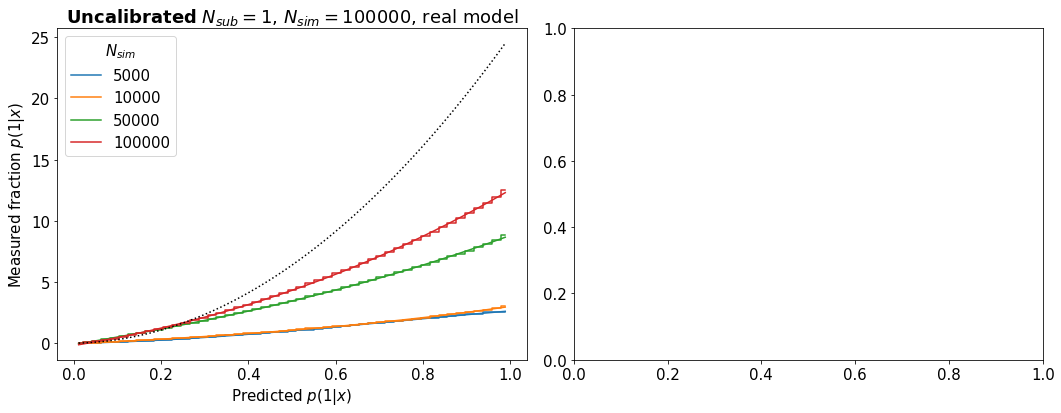

In [44]:
fig, axs = plt.subplots(1, 2, figsize = (15, 6), tight_layout = True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
titles = ['Uncalibrated', 'Calibrated']

for ax, fs, title in zip(axs, [fs_cumsum], titles):
    
    for f, entry, color, parm in zip(fs, entries, colors, parms_cumsum):
        ax.step(alpha_centers, f, label = f"{entry['nsim']}", where='mid', color = color)
        if ax == axs[0]:
            ax.plot(alpha_centers, np.poly1d(parm)(alpha_centers), color = color)
    ax.plot(alpha_centers, ideal, "k:")
    ax.set_xlabel(r'Predicted $p(1|x)$')
    ax.set_ylabel(r'Measured fraction $p(1|x)$')
    ax.set_title(rf'$\bf{title}$ $N_{{sub}} = {nsub}$, $N_{{sim}} = {nsim}$, {zero} model')
axs[0].legend(title = r'$N_{sim}$')

plt.show()